# Final Project - Ai for Finance

In [207]:
'''
#import the refinitiv eikon api library
import eikon as ek

#set the app-key (make sure the workspace is connected)
ek.set_app_key(app_key='085aca1d29a544338cab60f28acb8de0f7d54ac7')

#collect daily market data
data = ek.get_timeseries(["NVDA.O"], start_date="2022-06-15", end_date ="2023-06-14", interval='daily')

#collect daily news data
news = ek.get_news_headlines('R:NVDA.O AND Language:LEN AND NS:RTRS', date_to ="2023-06-06")
'''

'\n#import the refinitiv eikon api library\nimport eikon as ek\n\n#set the app-key (make sure the workspace is connected)\nek.set_app_key(app_key=\'085aca1d29a544338cab60f28acb8de0f7d54ac7\')\n\n#collect daily market data\ndata = ek.get_timeseries(["NVDA.O"], start_date="2022-06-15", end_date ="2023-06-14", interval=\'daily\')\n\n#collect daily news data\nnews = ek.get_news_headlines(\'R:NVDA.O AND Language:LEN AND NS:RTRS\', date_to ="2023-06-06")\n'

## Introduction
The aim of this project is to try and forecasting daily stock returns using Econometric Analysis , Machine learning and Recurrent Neural Network techniques
-   Methodologies:
    -   Econometrics analysis using Ordinary Least Squares Regression and Random Forest Classification
    -   Neural Networks: Long-Short Term Memory and Gated Recurrent Units

Due to an huge number of individuals with different ideas and resources constantly buying and selling , predicting how a stock will behave is a real challenge.
-   Main Challenges:
    -   Random Walk Hypothesis, stocks just behave in a total random manner
    -   Efficient Market Hypothesis, can't really 'beat' the market ... the prediction of a stock tomorrow would be  reflected in the price today

Can models trained by Recurrent Neural Networks predict returns more accurately than:
-   One-sided Prediction(Baseline): always predict the most probable outcome

Importing the libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import *
from keras.losses import MeanSquaredError, MeanAbsoluteError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam, SGD, Adamax

## Forecasting Model and Data Description
Return(t+1) = α + b0*Return(t) + b1*Market(t) + b2*Vol(t) + b3*SMB(t) + b4*HML(t) + b5*Term(t) + b6*Credit(t)

where:
-   Return(t) : Daily return of the financial asset with the subtraction of the daily risk-free securities
-   Market(t) : Daily market return with the subtraction of the daily risk-free securities
-   Vol(t) : Daily Percentage of volume traded
-   SMB(t) : Small Minus Big, accounts for publicly traded companies with small market caps that generate higher returns
-   HML(t) : High Minus Low, accounts for value stocks with high book-to-market ratios that generate higher returns in comparison to the market.
-   Term(t) : 10-Year Treasury Constant Maturity Minus 3-Month Treasury Constant Maturity
-   Credit(t) : Difference between Baa Corporate Bond Yield and Aaa Corporate Bond Yield

Database used:
-   Refinitiv Eikon, for financial asset data
-   Kenneth R. French, for fama-french factors
-   FRED Economic data, for Treasury and Corporate bond data

Asset: Nvidia Company (NVDA)

Loading data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#load famafrench factors
fama = pd.read_csv("./drive/MyDrive/data/famafrench.CSV")

#load 10-Year Treasury Constant Maturity Minus 3-Month Treasury Constant Maturity (from FRED Economic Data)
term = pd.read_csv('./drive/MyDrive/data/T10Y3M.csv')

#load Moody's Seasoned Aaa and Baa Corporate Bond Yield
aaa = pd.read_csv('./drive/MyDrive/data/DAAA.csv')
baa = pd.read_csv('./drive/MyDrive/data/DBAA.csv')

#Removing outdated Risk-free
fama = fama[fama['Date'].astype(int) > 20160601].reset_index(drop=True)

#Load Asset data (NVDA.O)
data = pd.read_excel('./drive/MyDrive/data/NVDA.xlsx')
data

,Exchange Date,Close,Net,%Chg,Open,Low,High,Volume,Turnover - USD,%CVol,%CTurn
0,2023-06-01,397.7000,19.3600,0.051171,384.890,383.4000,400.500,63587295,2.499878e+10,-0.365764,-0.353622
1,2023-05-31,378.3400,-22.7700,-0.056767,394.880,378.2200,402.950,100258020,3.867517e+10,0.085747,0.030116
2,2023-05-30,401.1100,11.6500,0.029913,405.950,399.4900,419.380,92340110,3.754450e+10,0.292561,0.363933
3,2023-05-26,389.4600,9.6600,0.025434,378.900,375.5000,391.700,71439676,2.752664e+10,-0.537281,-0.534508
4,2023-05-25,379.8000,74.4200,0.243696,385.230,366.3500,394.800,154391067,5.913457e+10,1.140104,1.548855
...,...,...,...,...,...,...,...,...,...,...,...
1758,2016-06-07,11.5825,0.0225,0.001946,11.630,11.5775,11.695,19340068,2.247504e+08,-0.400333,-0.398341
1759,2016-06-06,11.5600,-0.0600,-0.005164,11.650,11.5000,11.740,32251364,3.735512e+08,-0.300517,-0.299031
1760,2016-06-03,11.6200,-0.1650,-0.014001,11.670,11.4150,11.685,46107456,5.329070e+08,0.400557,0.376697
1761,2016-06-02,11.7850,0.0825,0.007050,11.765,11.6500,11.885,32920808,3.870910e+08,-0.149620,-0.144860


Data Cleaning

In [4]:
#drop irrelevant columns , we are just interested in the percentage excess returns
data.drop(['Net', 'Open', 'Low', 'High', 'Volume', 'Turnover - USD'], axis=1, inplace=True)

#reverse order
data = data[::-1].reset_index(drop=True)
data.dropna(inplace=True)

#reset indexes
data = data.reset_index(drop=True)


Adding all the features to the dataset

In [5]:
#Add all factors in one dataset
data = data.join(fama.drop(['Date'], axis=1))

#delete null values
data.dropna(inplace=True)

data.set_index('Exchange Date', inplace=True)

In [6]:
term["DATE"] = term["DATE"].astype("datetime64[ns]")
term.set_index('DATE', inplace=True)

aaa["DATE"] = aaa["DATE"].astype("datetime64[ns]")
aaa.set_index('DATE', inplace=True)
aaa["DAAA"] = aaa["DAAA"].astype("Float64")

baa["DATE"] = baa["DATE"].astype("datetime64[ns]")
baa.set_index('DATE', inplace=True)
baa["DBAA"] = baa["DBAA"].astype("Float64")

data = data.join(term)
data['Credit'] = baa['DBAA'] - aaa['DAAA']
data['Credit'] = data['Credit'].astype("float64")

Calculate the excess return of the asset adjusted by the daily risk free

In [7]:
#calculate excess returns
data['Excess Return'] = (data['%Chg'] * 100) - data['RF']
data.drop(['%Chg', 'RF'], axis=1, inplace=True)

#Show the final dataset
data

,Close,%CVol,%CTurn,Mkt-RF,SMB,HML,T10Y3M,Credit,Excess Return
Exchange Date,,,,,,,,,
2016-06-02,11.7850,-0.149620,-0.144860,0.35,0.33,-0.58,1.52,1.05,0.703978
2016-06-03,11.6200,0.400557,0.376697,-0.38,-0.16,-0.07,1.41,1.06,-1.401085
2016-06-06,11.5600,-0.300517,-0.299031,0.60,0.67,0.31,1.45,1.05,-0.517351
2016-06-07,11.5825,-0.400333,-0.398341,0.12,0.16,0.10,1.44,1.05,0.193637
2016-06-08,11.5450,0.213115,0.205884,0.37,0.45,-0.09,1.47,1.04,-0.324764
...,...,...,...,...,...,...,...,...,...
2023-04-24,270.4200,-0.016867,-0.016568,0.00,-0.40,0.47,-1.68,1.08,-0.301934
2023-04-25,262.4100,0.115672,0.097115,-1.76,-0.99,0.10,-1.72,1.07,-2.980059
2023-04-26,269.5600,0.073468,0.093099,-0.41,0.15,-0.75,-1.73,1.08,2.706744


Divide the dataset into a training set and a test set, we will test our models on 50 days (2 trading months)

In [8]:
#define the testing period range
forecast_horizon = 50

# Split data into test and train
train_set = data[:-forecast_horizon]
test_set = data[-forecast_horizon:]
print(f'train shape:{train_set.shape} test shape:{test_set.shape}')

train shape:(1689, 9) test shape:(50, 9)


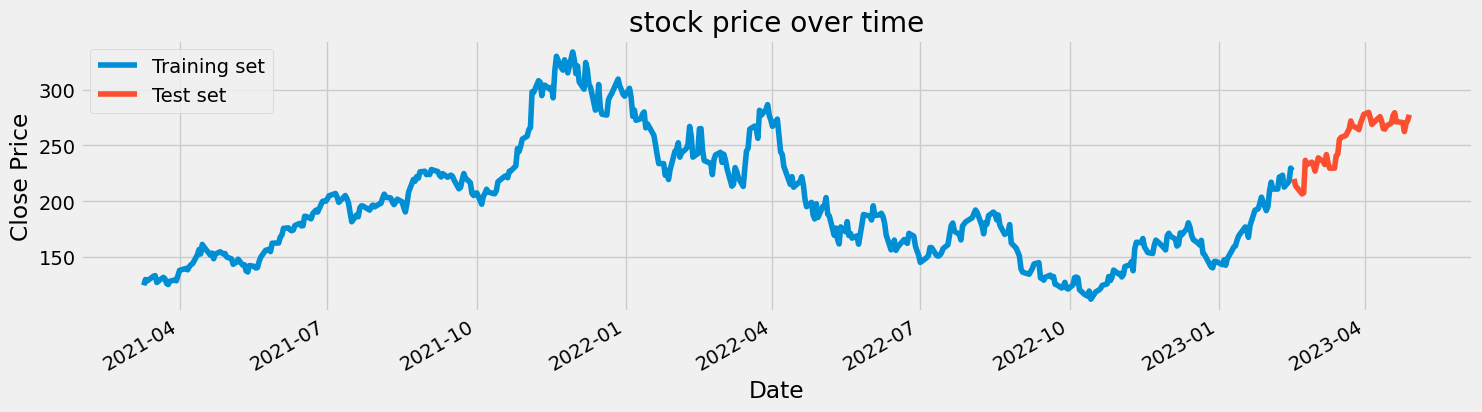

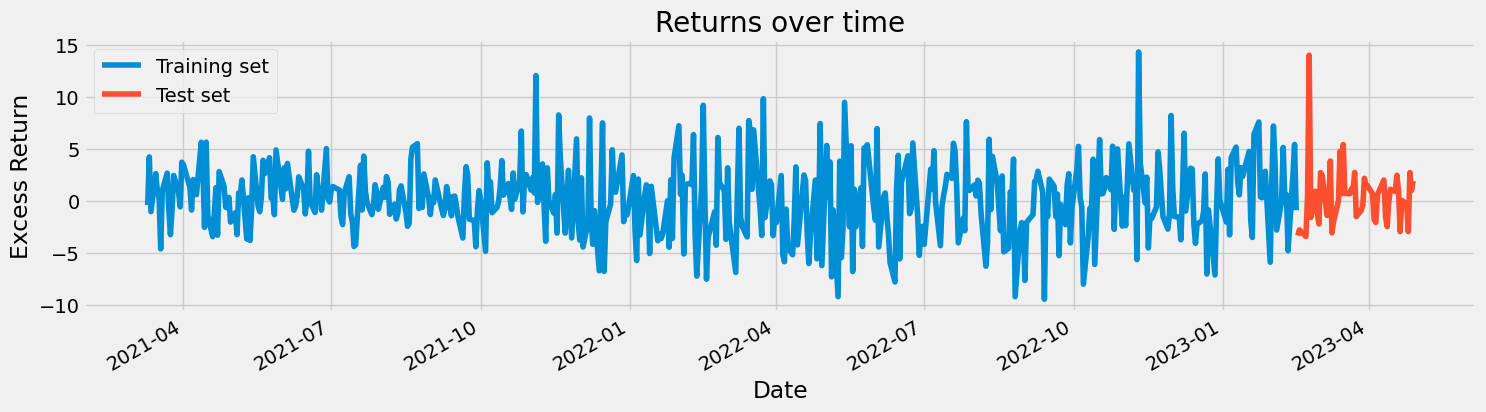

In [9]:
plt.style.use('fivethirtyeight')
train_set["Close"][1200:].plot(figsize=(16,4),legend=True)
test_set["Close"].plot(figsize=(16,4),legend=True)
plt.legend(['Training set','Test set'])
plt.title('stock price over time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

train_set["Excess Return"][1200:].plot(figsize=(16,4),legend=True)
test_set["Excess Return"].plot(figsize=(16,4),legend=True)
plt.legend(['Training set','Test set'])
plt.title('Returns over time')
plt.xlabel('Date')
plt.ylabel('Excess Return')
plt.show()

Since we are doing our analysis on a daily basis, we are not really interested on the asset price of tomorrow. what we are looking for is the orientation of our security, will the stock go up or down? do i have to keep it or sell it? That's why we will also try to forecast tomorrow return

## Exploratory Data Analysis

<Axes: title={'center': 'Correlation Matrix'}>

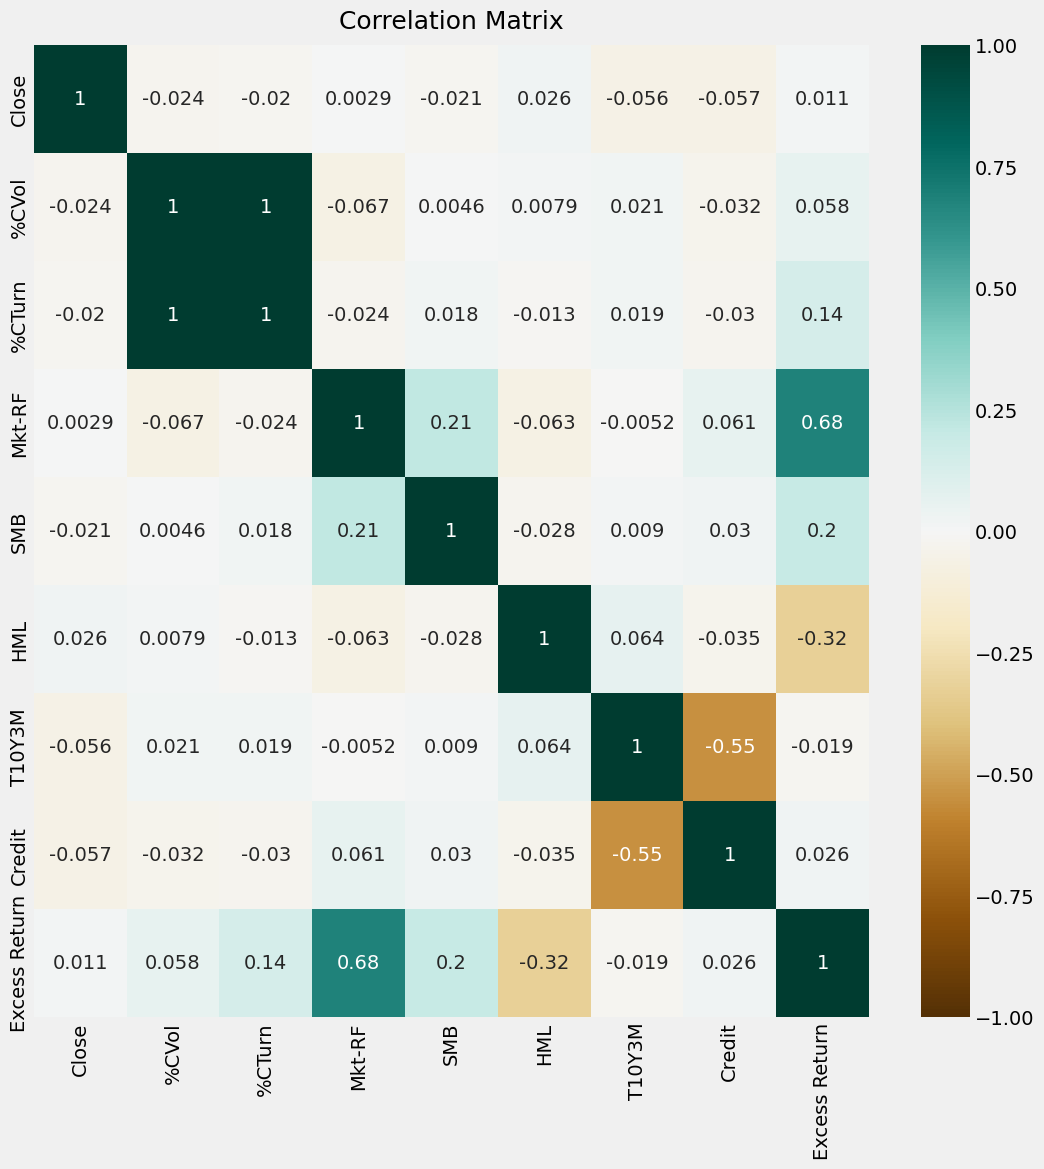

In [10]:
#Plotting the correlation matrix
plt.figure(figsize=(12, 12))
heatmap = sns.heatmap(data.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Matrix', fontdict={'fontsize':18}, pad=12)

heatmap

We can safely drop the % of Turnover since the information is already fully carried on from the % of Volume

In [11]:
#drop multicollinear features
data.drop(['%CTurn'], axis=1, inplace=True)

Let's plot some statistical description of our dataset, as we can see our data already have the mean centered around the zero, so we do not have to scale our data further.

(expecially for the factors related to price, it should be avoided to scale the data between a range since asset data could grow indefinitely)

In [12]:
data.describe()

,Close,%CVol,Mkt-RF,SMB,HML,T10Y3M,Credit,Excess Return
count,1739.000000,1739.000000,1739.000000,1739.000000,1739.000000,1739.000000,1739.000000,1739.000000
mean,101.719495,0.059132,0.048597,-0.002168,-0.007872,0.810811,0.904227,0.227449
std,77.817015,0.403416,1.249079,0.658586,0.992552,0.781796,0.209087,3.168006
min,11.310000,-0.636135,-12.000000,-3.570000,-5.000000,-1.730000,0.610000,-18.763867
25%,41.376250,-0.186172,-0.395000,-0.390000,-0.490000,0.290000,0.710000,-1.332858
50%,63.005000,-0.026774,0.070000,-0.010000,-0.040000,1.010000,0.890000,0.266666
75%,152.075000,0.205588,0.620000,0.370000,0.460000,1.400000,1.050000,1.846751
max,333.760000,3.808593,9.340000,5.480000,6.740000,2.270000,1.990000,29.805699


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1739 entries, 2016-06-02 to 2023-04-28
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Close          1739 non-null   float64
 1   %CVol          1739 non-null   float64
 2   Mkt-RF         1739 non-null   float64
 3   SMB            1739 non-null   float64
 4   HML            1739 non-null   float64
 5   T10Y3M         1739 non-null   float64
 6   Credit         1739 non-null   float64
 7   Excess Return  1739 non-null   float64
dtypes: float64(8)
memory usage: 186.8 KB


We now perform a lag of 1 day on the excess return so that we can treat our task as a binary classification problem (positive return vs negative return)

In [14]:
data['Tomorrow Return'] = data['Excess Return'].shift(-1)
data['Target'] = (data['Tomorrow Return'] > 0).astype(int)
data.dropna(inplace=True)
data

,Close,%CVol,Mkt-RF,SMB,HML,T10Y3M,Credit,Excess Return,Tomorrow Return,Target
Exchange Date,,,,,,,,,,
2016-06-02,11.7850,-0.149620,0.35,0.33,-0.58,1.52,1.05,0.703978,-1.401085,0
2016-06-03,11.6200,0.400557,-0.38,-0.16,-0.07,1.41,1.06,-1.401085,-0.517351,0
2016-06-06,11.5600,-0.300517,0.60,0.67,0.31,1.45,1.05,-0.517351,0.193637,1
2016-06-07,11.5825,-0.400333,0.12,0.16,0.10,1.44,1.05,0.193637,-0.324764,0
2016-06-08,11.5450,0.213115,0.37,0.45,-0.09,1.47,1.04,-0.324764,2.597528,1
...,...,...,...,...,...,...,...,...,...,...
2023-04-21,271.1900,-0.193145,0.07,0.26,-0.92,-1.57,1.07,0.037342,-0.301934,0
2023-04-24,270.4200,-0.016867,0.00,-0.40,0.47,-1.68,1.08,-0.301934,-2.980059,0
2023-04-25,262.4100,0.115672,-1.76,-0.99,0.10,-1.72,1.07,-2.980059,2.706744,1


## Econometric Analysis

Printing some econometric statistics to see the trend of our asset over time

In [15]:
#Printing Average Excess Return volatility and Sharpe-ratio over time
print('Average Excess Return: {:.3f}'.format( np.mean(data['Excess Return'])))
print('Volatility: {:.3f}'.format(np.std(data['Excess Return'])))
print('Sharpe-ratio: {:.3f}'.format(np.mean(data['Excess Return']) / np.std(data['Excess Return'])))

#Printing Average Excess Return volatility and Sharpe-ratio over last year
print('\n####last trading year####')
print('Average Excess Return: {:.3f}'.format( np.mean(data.iloc[-250:]['Excess Return'])))
print('Volatility: {:.3f}'.format(np.std(data.iloc[-250:]['Excess Return'])))
print('Sharpe-ratio: {:.3f}'.format(np.mean(data.iloc[-250:]['Excess Return']) / np.std(data.iloc[-250:]['Excess Return'])))

Average Excess Return: 0.226
Volatility: 3.168
Sharpe-ratio: 0.071

####last trading year####
Average Excess Return: 0.186
Volatility: 3.717
Sharpe-ratio: 0.050


Let's see how the beta of the market factor is related to our stock return using OLS regression

In [16]:
#compute the Ordinary Least Squares Regression

#OLS with market data
X = data['Mkt-RF']
y = data['Excess Return']

#add the constant bias
X_sm = sm.add_constant(X)

#fitting the model to the data
model = sm.OLS(y, X_sm)
results = model.fit()

#plotting the model results
print(results.summary())
print('alpha: ', results.params[0])
print('beta: ', results.params[1])

                            OLS Regression Results                            
Dep. Variable:          Excess Return   R-squared:                       0.467
Model:                            OLS   Adj. R-squared:                  0.466
Method:                 Least Squares   F-statistic:                     1519.
Date:                Mon, 19 Jun 2023   Prob (F-statistic):          2.86e-239
Time:                        16:52:13   Log-Likelihood:                -3923.7
No. Observations:                1738   AIC:                             7851.
Df Residuals:                    1736   BIC:                             7862.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1430      0.056      2.574      0.0

We can see how only the market factor has a R-squared of 0.467 which means that the market only factor it is already  explaining nearly half of the data. also the beta factor is 1.73, this is not surpising that the company is almost doubling the market, from a big tech company with an great volatility(risk) we expect greater returns!

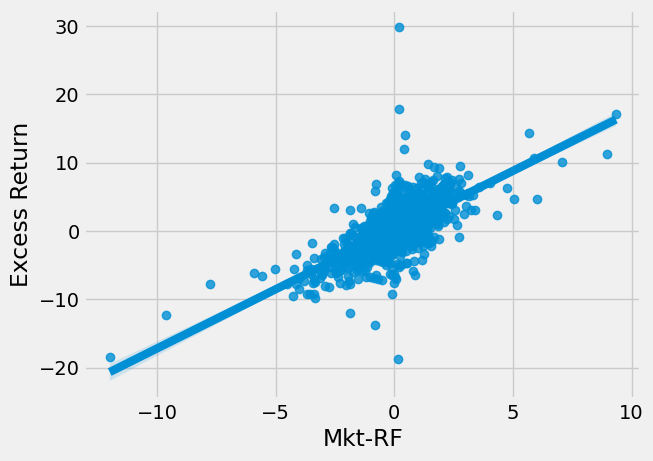

In [17]:
#plotting the results
sns.regplot(x='Mkt-RF', y='Excess Return', data=data)
plt.show()

Let's now add all the factors to the model

In [18]:
#OLS with all the variables
predictors = ['Mkt-RF', 'SMB', 'HML', '%CVol', 'T10Y3M', 'Credit']

X = data[predictors]
y = data['Excess Return']

X_sm = sm.add_constant(X)
model = sm.OLS(y, X_sm)
results = model.fit()

print(results.summary())
print('alpha: ', results.params[0])
print('beta: ', results.params[1])

                            OLS Regression Results                            
Dep. Variable:          Excess Return   R-squared:                       0.560
Model:                            OLS   Adj. R-squared:                  0.558
Method:                 Least Squares   F-statistic:                     366.6
Date:                Mon, 19 Jun 2023   Prob (F-statistic):          6.55e-304
Time:                        16:52:17   Log-Likelihood:                -3757.4
No. Observations:                1738   AIC:                             7529.
Df Residuals:                    1731   BIC:                             7567.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5709      0.307      1.858      0.0

by adding more factor we increased our R-squared which is good, we can explain a greater amount of data , and we can also see that the Yield maturity and credit are statistically insignificant

In [19]:
#OLS with 1 day shift
predictors = ['Mkt-RF', 'SMB', 'HML', '%CVol', 'T10Y3M', 'Credit', 'Excess Return']
X = data[predictors]
y = data['Tomorrow Return']

X_sm = sm.add_constant(X)
model = sm.OLS(y, X_sm)
results = model.fit()

print(results.summary())
print('alpha: ', results.params[0])
print('beta: ', results.params[1])

                            OLS Regression Results                            
Dep. Variable:        Tomorrow Return   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     7.208
Date:                Mon, 19 Jun 2023   Prob (F-statistic):           1.58e-08
Time:                        16:52:19   Log-Likelihood:                -4445.2
No. Observations:                1738   AIC:                             8906.
Df Residuals:                    1730   BIC:                             8950.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0126      0.457      0.028

In [20]:
#define a function for plotting the results
def plot_pred(test,pred):
    plt.plot(test, color='red',label='Real Return')
    plt.plot(pred, color='blue',label='Predicted Return')
    plt.title('Excess Returns Prediction')
    plt.xlabel('Time')
    plt.ylabel('Return')
    plt.legend()
    plt.show()

def plot_prices(test,pred):
    plt.plot(test, color='red',label='Real Price')
    plt.plot(pred, color='blue',label='Predicted Price')
    plt.title('Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Asset Price')
    plt.legend()
    plt.show()

def return_rmse(test,pred):
    rmse = np.sqrt(mean_squared_error(test, pred))
    print("root mean squared error: {}.".format(rmse))

Since we were not able to explain the returns of tomorrow with a linear regression model (as we said before , stock prices are highly non linear), let's try to see if we can capture those non linearities with a random forest classifier

In [36]:
from sklearn.ensemble import RandomForestClassifier

train_set = data.iloc[:forecast_horizon]
test_set = data.iloc[-forecast_horizon:]

#we can add the returns of today as a feature to help predicting the returns of tomorrow
predictors = ['Mkt-RF', 'SMB', 'HML', '%CVol', 'T10Y3M', 'Credit', 'Excess Return']

#splitting the train and test set
X_train, y_train = train_set[predictors], train_set['Target']
X_test, y_test = test_set[predictors], test_set['Target']

#tuning hyperparameters with GridSearchCV
classifier = RandomForestClassifier()
parameters = {'n_estimators':[5,10],
              'class_weight':[{0:1,1:2}, {0:2,1:3}],
              'criterion':['gini', 'entropy'],
              'max_depth':[10,None],
             'min_samples_split':[2,10]}

clf = GridSearchCV(classifier, parameters)
clf.fit(X_train, y_train)

#print the best parameters found by GridSearch
print(clf.best_params_)

{'class_weight': {0: 1, 1: 2}, 'criterion': 'gini', 'max_depth': None, 'min_samples_split': 10, 'n_estimators': 5}


In [37]:
from sklearn.metrics import precision_score

#fit the model
model = clf.best_estimator_
model.fit(X_train, y_train)

#make predictions
y_pred = model.predict(X_test)
y_pred = pd.Series(y_pred, index=test_set.index)

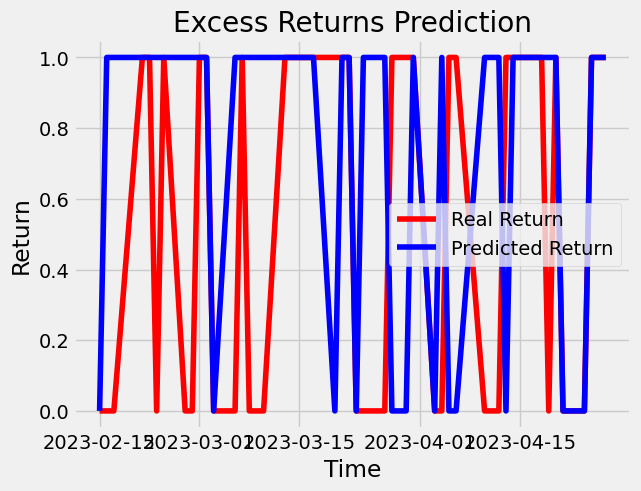

precision score: 0.5675675675675675
baseline:  1    0.56
0    0.44
Name: Target, dtype: float64


In [38]:
results_rf = pd.DataFrame(data={'Actual Orientation': y_test, 'Predicted Orientation': y_pred})
plot_pred(results_rf['Actual Orientation'], results_rf['Predicted Orientation'])

score_rf = precision_score(y_test, y_pred)
print('precision score:', score_rf)
print('baseline: ',y_test.value_counts() / len(y_test))

We can compare the precision score of the classifier against the One-sided prediction assumption and see that the random forest classifier did slightly better that predicting always the most probable outcome (0.56)

### Feature Ranking

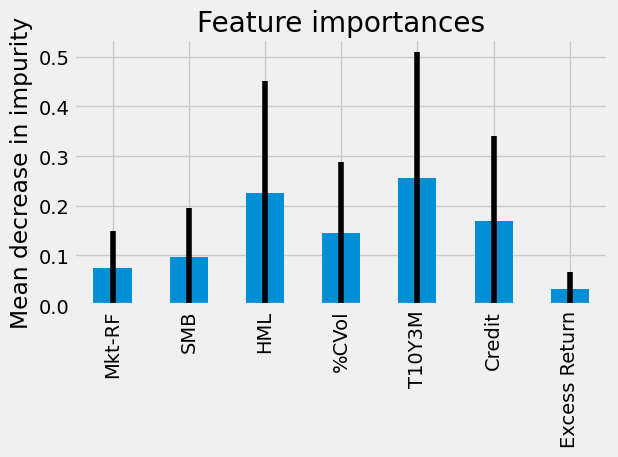

In [39]:
importances = model.feature_importances_
forest_importances = pd.Series(importances, index=X_train.columns)
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
mean = np.mean([tree.feature_importances_ for tree in model.estimators_], axis=0)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=mean, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.show()

## Neural Network Analysis


In [40]:
#function for creating time series sequences
def time_series(df, future=1, past=14, returns=True):
    X = []
    y = []
    for i in range(past, len(df) - future + 1):
        X.append(df.iloc[i - past:i, 0:df.shape[1]])
        if returns:
            y.append(df.iloc[i + future - 1: i + future, -1])
        else:
            y.append(df.iloc[i + future - 1: i + future, 0])

    return np.array(X), np.array(y)

### Baseline: forecasting asset closing price using the previous prices

In [41]:
from sklearn.preprocessing import MinMaxScaler

train_data, test_data = data[:-forecast_horizon], data[-forecast_horizon:]

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(train_data['Close'].values.reshape(-1,1))

X_train = []
y_train = []

for x in range(forecast_horizon, len(scaled_data)):
    X_train.append(scaled_data[x-forecast_horizon:x, 0])
    y_train.append(scaled_data[x,0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [ ]:
# The LSTM architecture
regressor = Sequential()

# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=False))
regressor.add(Dropout(0.2))

# The output layer
regressor.add(Dense(8))
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='adam',loss='mean_squared_error')

# Fitting to the training set
regressor.fit(X_train,y_train,epochs=50,batch_size=16)

In [43]:
actual_prices = test_data['Close'].values
total_dataset = pd.concat( (train_data['Close'], test_data['Close']), axis=0)
model_inputs = total_dataset[len(total_dataset) - len(test_data) - forecast_horizon:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)

2/2 [==============================] - 1s 8ms/step


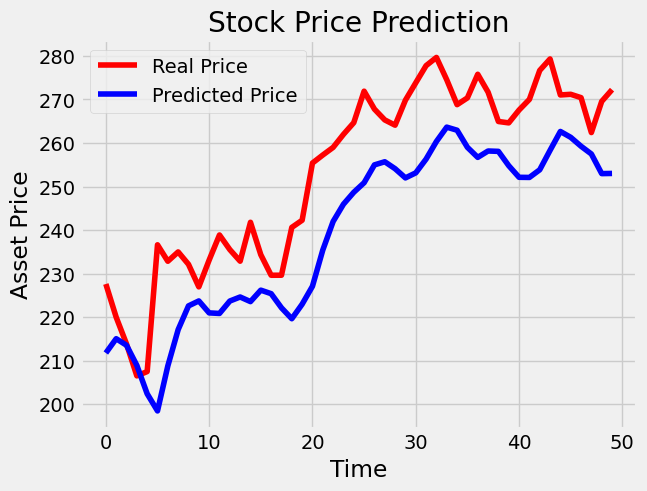

In [44]:
X_test = []

for x in range(forecast_horizon, len(model_inputs)):
    X_test.append(model_inputs[x-forecast_horizon:x, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

predicted_prices = regressor.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

plot_prices(actual_prices, predicted_prices)

Even if the predicted curve follows quite nicely the real asset prices, it should be taken into account that we are doing daily forecasting, using actual data to predict only the price of tomorrow. in the real world we would not be able to forecast the 50th day until the previous 49 days have passed.

(Note: scaling price data between a minimum and maximum value should be avoided since asset prices could grow indefinitely)

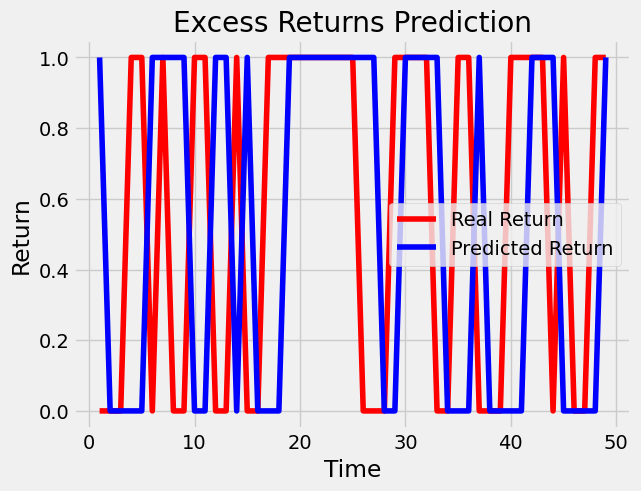

precision score: 0.5384615384615384
baseline:  1    0.571429
0    0.428571
Name: Actual Orientation, dtype: float64


In [45]:
results = pd.DataFrame(data={'Actual': actual_prices.flatten(), 'Predicted': predicted_prices.flatten()})
results['Actual Yesterday'] = results['Actual'].shift(1)
results['Predicted Yesterday'] = results['Predicted'].shift(1)
results['Actual Orientation'] = (results['Actual'] > results['Actual Yesterday']).astype(int)
results['Predicted Orientation'] = (results['Predicted'] > results['Predicted Yesterday']).astype(int)
results.dropna(inplace=True)

plot_pred(results['Actual Orientation'], results['Predicted Orientation'])

print('precision score:', precision_score(results['Actual Orientation'], results['Predicted Orientation']))
print('baseline: ',results['Actual Orientation'].value_counts() / len(results['Actual Orientation']))

If we compare the returns predicted from the baseline we can see how it does worse than the one-sided prediction assumption

### Long-Short Term Memomy (LSTM) model for Stock Returns forecasting

In [46]:
#define the features to feed into the lstm model
predictors = ['Mkt-RF', 'SMB', 'HML', '%CVol', 'T10Y3M', 'Credit', 'Excess Return']

n_futures = 1   #number of days we want to forecast
n_past = 50     #number of past days we want to use to forecast

train , test = data[:-(forecast_horizon - 1)], data[-(forecast_horizon + n_futures + n_past - 1):]
print(f'train data: {train.shape} test data: {test.shape}')

#create the temporal time-series
X_train, y_train = time_series(train[predictors], future=n_futures, past=n_past)
X_test, y_test = time_series(test[predictors], future=n_futures, past=n_past)
print(f'X train {X_train.shape} Y train {y_train.shape}')
print(f'X test {X_test.shape} Y test {y_test.shape}')

train data: (1689, 10) test data: (100, 10)
X train (1639, 50, 7) Y train (1639, 1)
X test (50, 50, 7) Y test (50, 1)


In [47]:
# The LSTM architecture
regressor = Sequential()

# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=forecast_horizon, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
regressor.add(Dropout(0.2))

# Second LSTM layer
regressor.add(LSTM(units=forecast_horizon, return_sequences=False))
regressor.add(Dropout(0.2))

# The output layer
regressor.add(Dense(8))
regressor.add(Dense(units=1))

regressor.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 50, 50)            11600     
                                                                 
 dropout_2 (Dropout)         (None, 50, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 8)                 408       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 32,217
Trainable params: 32,217
Non-trai

In [ ]:
# Compiling the RNN
#regressor.compile(optimizer='rmsprop',loss='mean_absolute_error')
regressor.compile(optimizer='adam',loss='mean_squared_error')

# Fitting to the training set
regressor.fit(X_train,y_train,epochs=200,batch_size=16)

2/2 [==============================] - 1s 7ms/step


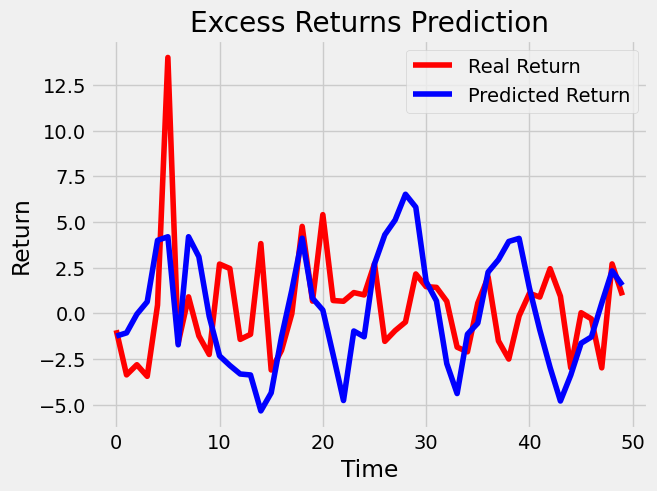

In [52]:
# Testing on the test set
forecast = regressor.predict(X_test)
plot_pred(y_test, forecast)

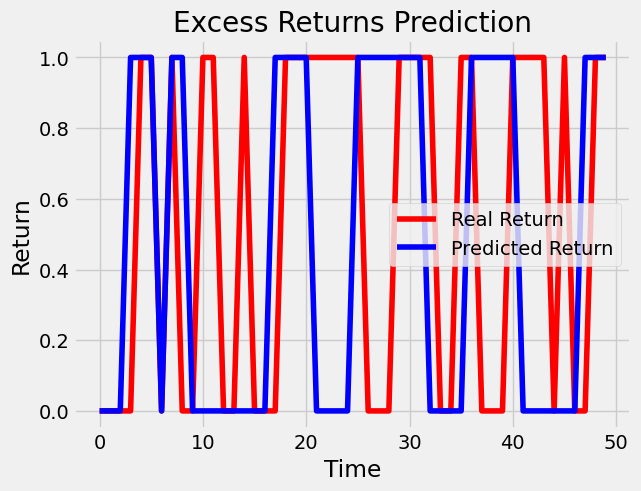

precision score: 0.5833333333333334
baseline:  1    0.54
0    0.46
Name: Actual Orientation, dtype: float64


In [53]:
results_lstm = pd.DataFrame(data={'Actual': y_test.flatten(), 'Predicted': forecast.flatten()})
results_lstm['Actual Orientation'] = (results_lstm['Actual'] > 0).astype(int)
results_lstm['Predicted Orientation'] = (results_lstm['Predicted'] > 0).astype(int)

plot_pred(results_lstm['Actual Orientation'], results_lstm['Predicted Orientation'])

score_lstm = precision_score(results_lstm['Actual Orientation'], results_lstm['Predicted Orientation'])
print('precision score:', score_lstm)
print('baseline: ',results_lstm['Actual Orientation'].value_counts() / len(results_lstm['Actual Orientation']))

### Gated Recurrent Units (GRU) model for Stock Returns forecasting

In [54]:
# The GRU architecture
regressorGRU = Sequential()
# First GRU layer with Dropout regularization
regressorGRU.add(GRU(units=forecast_horizon, return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2]), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(GRU(units=forecast_horizon, activation='tanh', return_sequences=False))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=8))
regressorGRU.add(Dense(units=1))

regressorGRU.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 50, 50)            8850      
                                                                 
 dropout_4 (Dropout)         (None, 50, 50)            0         
                                                                 
 gru_1 (GRU)                 (None, 50)                15300     
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_4 (Dense)             (None, 8)                 408       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 24,567
Trainable params: 24,567
Non-trai

In [ ]:
# Compiling the RNN
regressorGRU.compile(optimizer='adam', loss='mean_squared_error')
# Fitting to the training set
regressorGRU.fit(X_train,y_train,epochs=200,batch_size=16)

2/2 [==============================] - 1s 7ms/step


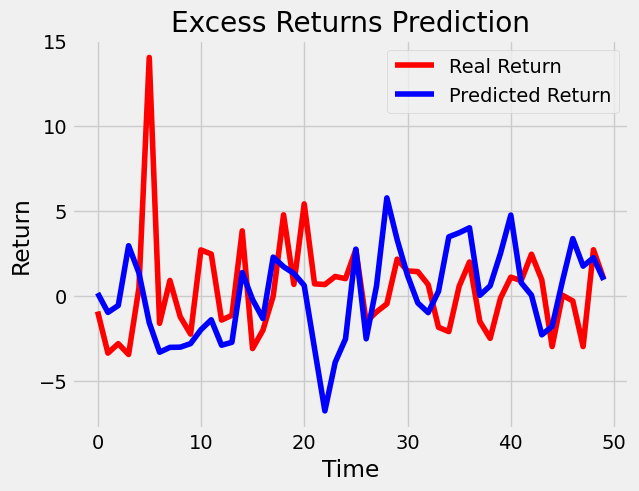

In [56]:
forecast = regressorGRU.predict(X_test)
plot_pred(y_test, forecast)

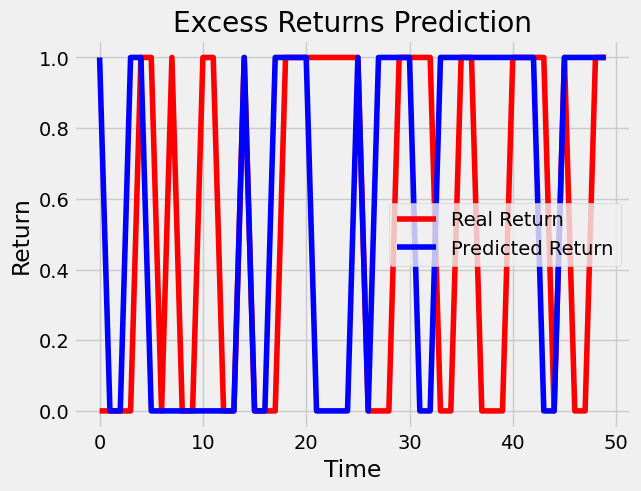

precision score: 0.5714285714285714
baseline:  1    0.54
0    0.46
Name: Actual Orientation, dtype: float64


In [57]:
results_gru = pd.DataFrame(data={'Actual': y_test.flatten(), 'Predicted': forecast.flatten()})
results_gru['Actual Orientation'] = (results_gru['Actual'] > 0).astype(int)
results_gru['Predicted Orientation'] = (results_gru['Predicted'] > 0).astype(int)

plot_pred(results_gru['Actual Orientation'], results_gru['Predicted Orientation'])

score_gru = precision_score(results_gru['Actual Orientation'], results_gru['Predicted Orientation'])
print('precision score:', score_gru)
print('baseline: ',results_gru['Actual Orientation'].value_counts() / len(results_gru['Actual Orientation']))

## Conclusions


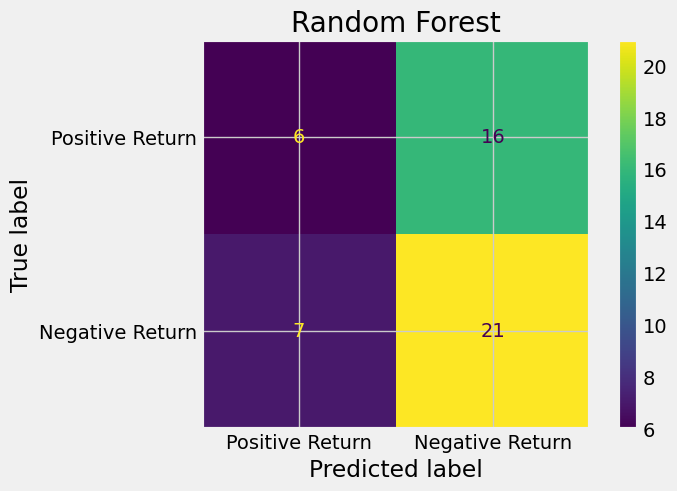

Precision score:  0.5675675675675675


In [66]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(results_rf['Actual Orientation'], results_rf['Predicted Orientation'])
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['Positive Return', 'Negative Return'])
cm_display.plot()
plt.title('Random Forest')
plt.show()
print('Precision score: ', score_rf)

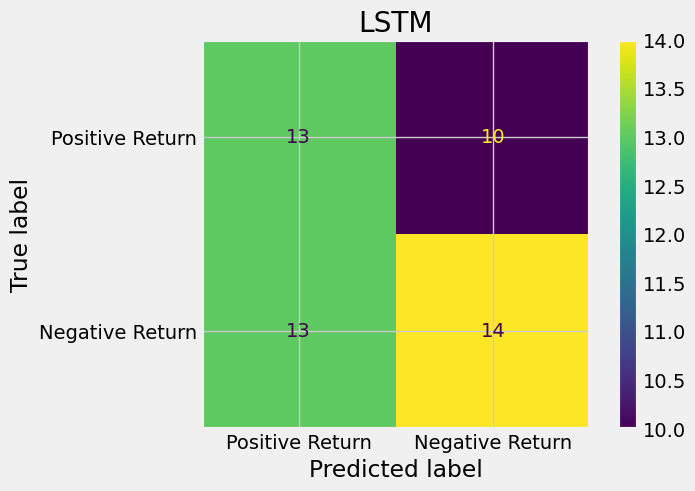

Precision score:  0.5833333333333334


In [67]:
cm = confusion_matrix(results_lstm['Actual Orientation'], results_lstm['Predicted Orientation'])
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['Positive Return', 'Negative Return'])
cm_display.plot()
plt.title('LSTM')
plt.show()
print('Precision score: ', score_lstm)

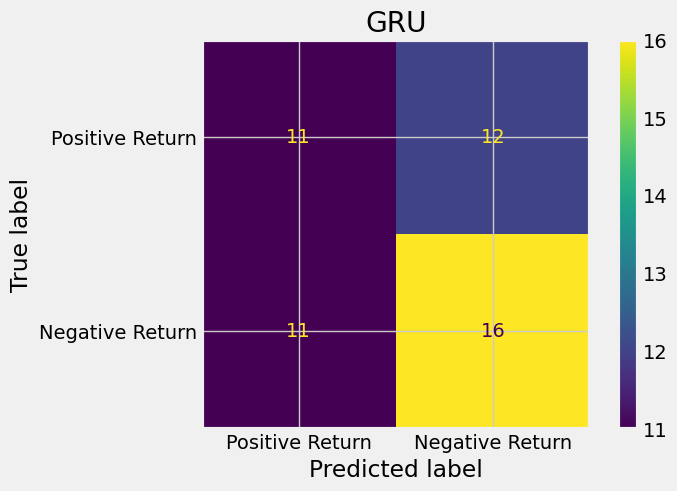

Precision score:  0.5714285714285714


In [68]:
cm = confusion_matrix(results_gru['Actual Orientation'], results_gru['Predicted Orientation'])
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['Positive Return', 'Negative Return'])
cm_display.plot()
plt.title('GRU')
plt.show()
print('Precision score: ', score_gru)

The model trained using recurrent neural networks (LSTM) has shown better performance in comparison to the classical machine learning technique.

By adding other factors we further increased the predictive power of the model with respect to the baseline

## Future Works

The next step could be to add more features to better capture the non-linearity of the stock market (like seasonality, growth rate, inflation..), one possible approach could be to collect daily news and by using a pre-trained sentiment analysis classifier, assign a daily sentiment score as an extra feature and see how it perform